# Intelligent Placer and Checker (ML 2021)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv
import cv2
from imageio import imread, imsave
from skimage.feature import canny
from skimage.filters import gaussian
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte
from skimage.filters import threshold_otsu, rank, try_all_threshold, threshold_li, threshold_local
from skimage.transform import (hough_line, hough_line_peaks, probabilistic_hough_line)
from matplotlib import cm
from matplotlib.patches import Rectangle
from scipy.ndimage.morphology import binary_fill_holes
from skimage.morphology import watershed, binary_erosion, binary_opening, disk, binary_closing


## Тест для произвольной фотки

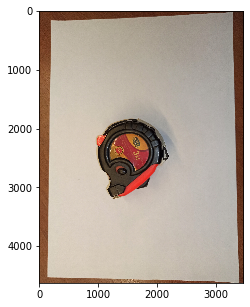

In [2]:
def read_image(filename):
    directory = "ML2021Dataset"
    path = os.path.join(directory, filename)
    original_image = imread(path)
    return original_image

original_image = read_image("IMG_20210921_214051" + ".jpg")
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(original_image)

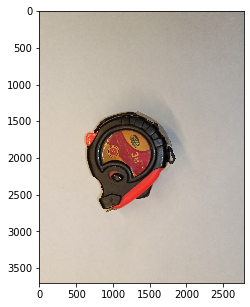

In [3]:
def cut_edges(original_image, cut_threshold):
    h, w, _ = original_image.shape
    cropped_image = original_image[(int)(h*cut_threshold):(int)(h*(1-cut_threshold)), (int)(w*cut_threshold):(int)(w*(1-cut_threshold))]
    return cropped_image

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
cropped_image = cut_edges(original_image, 0.1)
ax.imshow(cropped_image)

Попробуем предобработать изображение с помощью бинаризации:

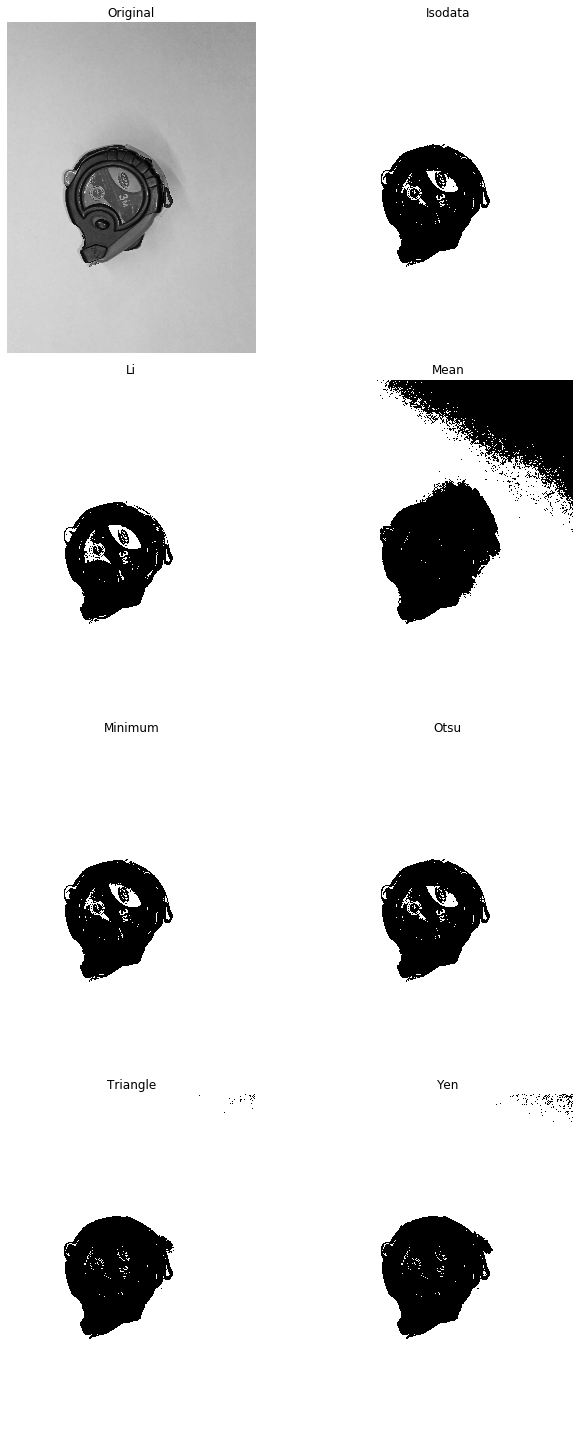

In [4]:
fig, ax = try_all_threshold(rgb2gray(cropped_image), figsize=(10, 20), verbose=False)
plt.show()

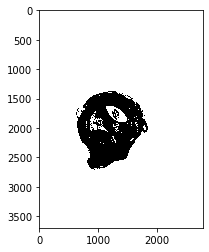

In [5]:
binary_gray = rgb2gray(cropped_image)
threshold = threshold_li(binary_gray)

ret, binary_image = cv2.threshold(binary_gray, threshold, 1, cv2.THRESH_BINARY)
#binary_image = binary_gray > threshold

plt.imshow(binary_image, cmap='gray')
plt.show()

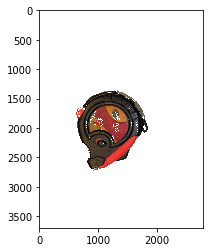

In [6]:
def crop_by_mask(src_image):
    image = src_image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #threshold = threshold_li(gray)
    threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    result = cv2.bitwise_and(image, image, mask=threshold)
    result[threshold==0] = [255,255,255]
    return result

result = crop_by_mask(cropped_image)
plt.imshow(result)

## Прогоним для всех фотографий

55


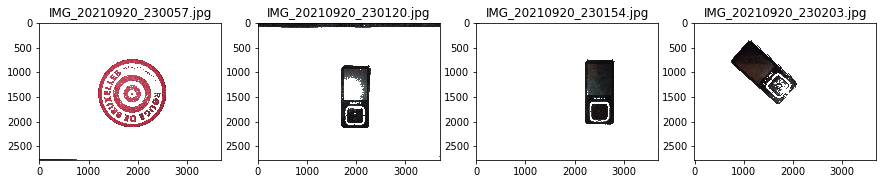

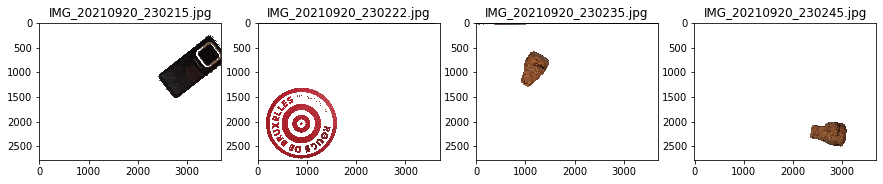

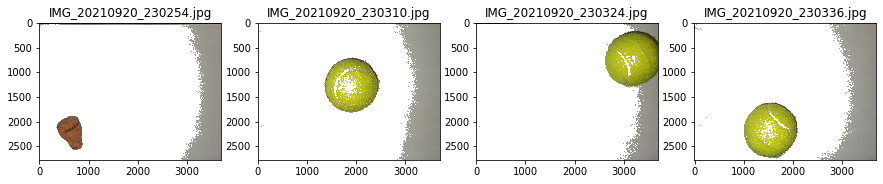

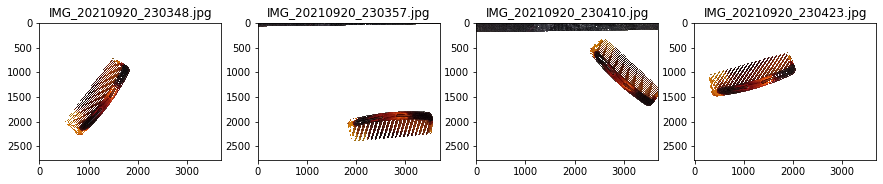

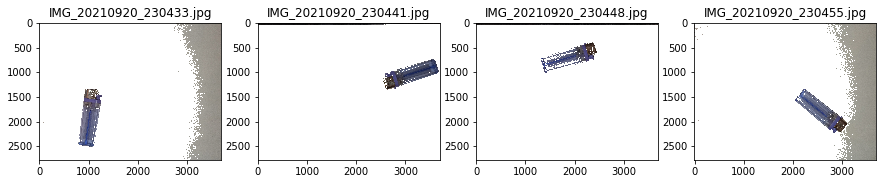

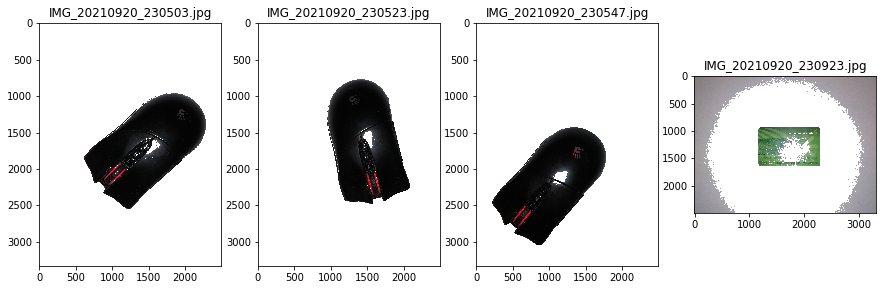

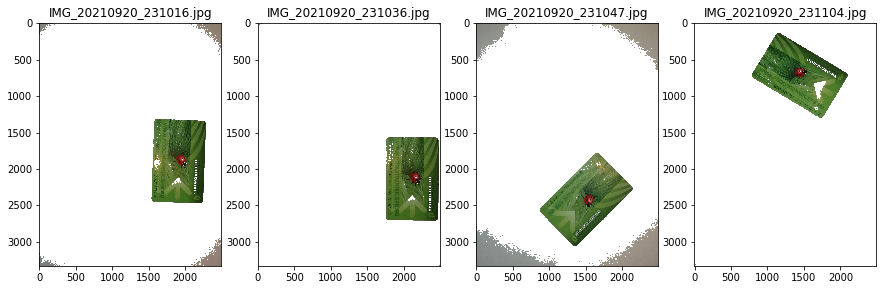

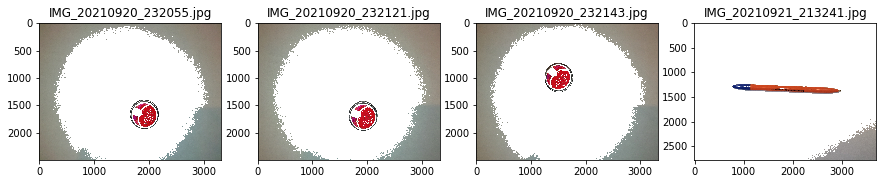

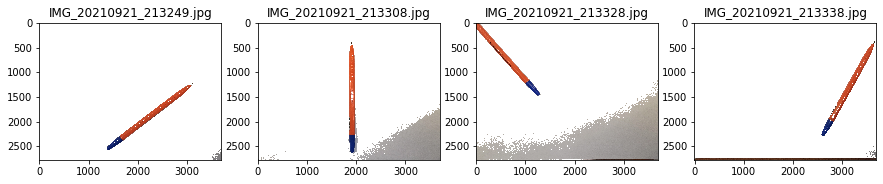

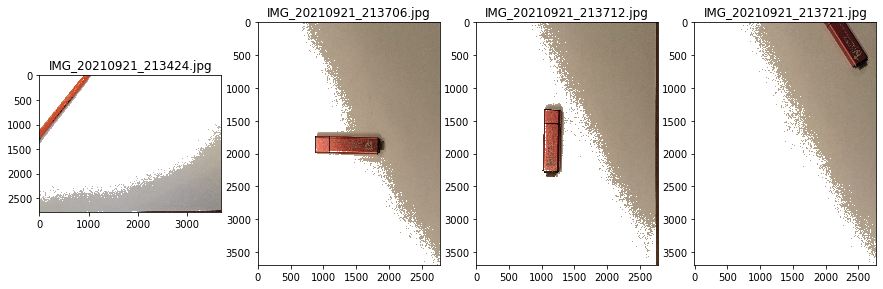

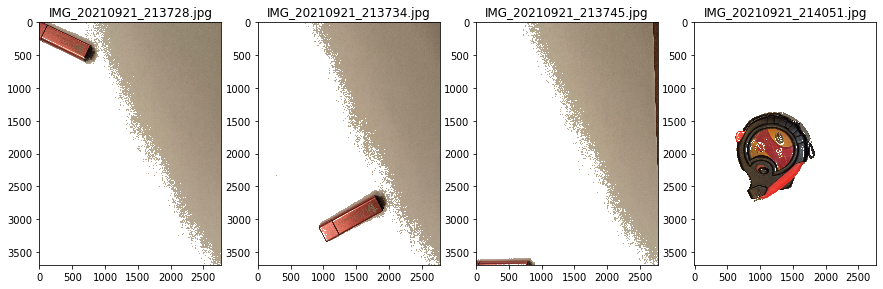

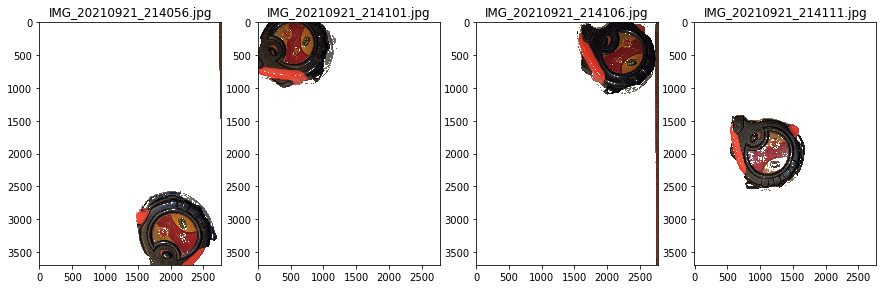

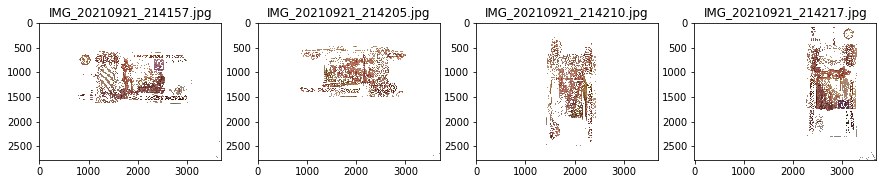

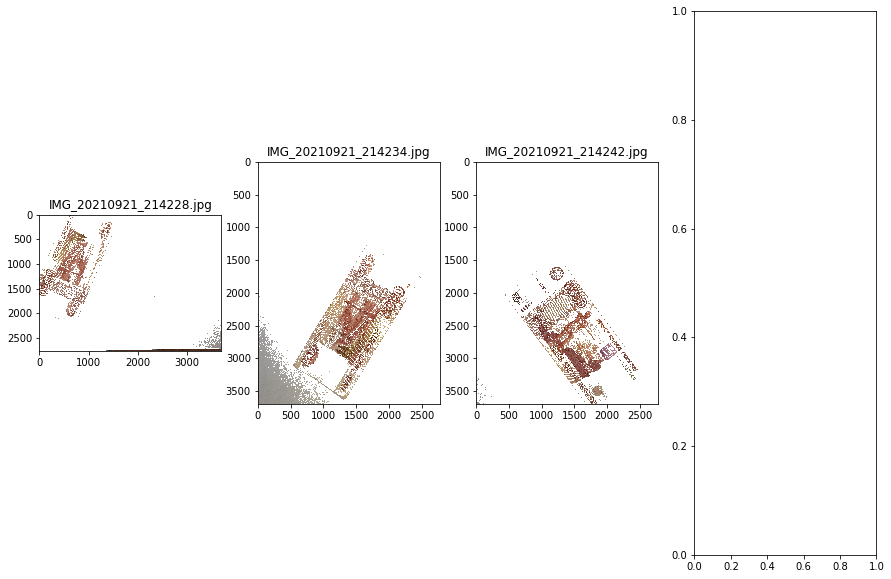

In [15]:
from os import listdir
from os.path import isfile, join

directory = "ML2021Dataset"

allFiles = [f for f in listdir(directory) if isfile(join(directory, f))]
#allFiles = allFiles[0:3]
print(len(allFiles))

for i in range(len(allFiles)):
    count_in_raw = 4
    if (i % count_in_raw == 0):
        fig, ax = plt.subplots(1, count_in_raw, figsize=(15, 10))
    filename = allFiles[i]
    image = read_image(filename)
    image_cropped = cut_edges(image, 0.1)
    result = crop_by_mask(image_cropped)
    ax.flatten()[i%count_in_raw].set_title(filename)
    ax.flatten()[i%count_in_raw].imshow(result)

    
    